# Discrete probabilistic methods

## overall takeaways:
- `97.105.19.58` is probably a web scraper as the timedelta between requests is usually < 1 second
- `173.173.113.51 ` looks like someone trying out a web scraper as the time is sometimes longer than 1 second, but there are also a lot of pings to the server
- `72.181.113.170` looks similar to  `173.173.113.51 `


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import env

In [21]:
query_str = """SELECT * FROM api_access;"""

df = pd.read_sql_query(query_str, env.get_db_url('logs'))

In [22]:
def parse_log_entry(entry):
    parts = entry.split()
    output = {}
    output['ip'] = parts[0]
    output['timestamp'] = parts[3][1:].replace(':', ' ', 1)
    output['request_method'] = parts[5][1:]
    output['request_path'] = parts[6]
    output['http_version'] = parts[7][:-1]
    output['status_code'] = parts[8]
    output['size'] = int(parts[9])
    output['user_agent'] = ' '.join(parts[11:]).replace('"', '')
    return pd.Series(output)

df = df.entry.apply(parse_log_entry)
df.timestamp = pd.to_datetime(df.timestamp)

In [23]:
df

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13974 entries, 0 to 13973
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   ip              13974 non-null  object        
 1   timestamp       13974 non-null  datetime64[ns]
 2   request_method  13974 non-null  object        
 3   request_path    13974 non-null  object        
 4   http_version    13974 non-null  object        
 5   status_code     13974 non-null  object        
 6   size            13974 non-null  int64         
 7   user_agent      13974 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 873.5+ KB


In [117]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )

## check the value counts of the different columns

In [9]:
#majority of ips are 97.105.19.58
# these are all public ip addresses
df.ip.value_counts()

97.105.19.58      11998
173.173.113.51     1059
72.181.113.170      613
72.181.105.81       246
24.26.242.9          21
68.201.219.223       21
70.121.214.34         2
52.87.230.102         2
35.175.171.137        2
54.145.52.184         1
3.92.201.136          1
35.174.209.2          1
34.229.70.250         1
54.172.14.223         1
34.207.64.242         1
3.88.129.158          1
52.91.30.150          1
52.90.165.200         1
45.23.250.16          1
Name: ip, dtype: int64

In [10]:
df.timestamp.value_counts()

16/Apr/2019 19:56:10    9
16/Apr/2019 19:49:58    8
16/Apr/2019 20:01:30    7
16/Apr/2019 20:12:23    6
16/Apr/2019 20:02:59    6
                       ..
16/Apr/2019 21:10:09    1
16/Apr/2019 21:10:07    1
16/Apr/2019 21:10:05    1
16/Apr/2019 21:10:03    1
17/Apr/2019 12:55:14    1
Name: timestamp, Length: 9953, dtype: int64

In [11]:
df.request_method.value_counts()

GET    13974
Name: request_method, dtype: int64

In [12]:
df.request_path.value_counts()

/api/v1/sales?page=2                 709
/api/v1/items                        464
/api/v1/items?page=2                 291
/api/v1/items?page=3                 219
/api/v1/stores                       162
                                    ... 
/api/v1/items?page=0                   1
/api/v1/stores?page=999                1
/api/v1/stores?page=2                  1
/api/v1/stores?page=666                1
/api/v1/items/api/v1/items?page=3      1
Name: request_path, Length: 218, dtype: int64

There are a lot of values here and looking at come of these in conjunction with status_code would be helpful

In [13]:
df.http_version.value_counts()

HTTP/1.1    13974
Name: http_version, dtype: int64

In [14]:
df.status_code.value_counts()

200    13958
499       16
Name: status_code, dtype: int64

The 499 indicates the server is Nginx server, and indicates a client closed request. 200 is OK

In [15]:
df.user_agent.value_counts()

python-requests/2.21.0                                                                                                       12001
python-requests/2.20.1                                                                                                        1911
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36       34
Mozilla/5.0 (Macintosh; Intel Mac OS X 10.14; rv:66.0) Gecko/20100101 Firefox/66.0                                               8
Slackbot-LinkExpanding 1.0 (+https://api.slack.com/robots)                                                                       7
Slackbot 1.0 (+https://api.slack.com/robots)                                                                                     6
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.103 Safari/537.36        4
Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_3) AppleWebKit/537.36 (KHTML, like Gec

Depending on context some of these might be suspicious.  Everything but the python-requests probably should be checked individually since these are not many.

In [17]:
df['size'].describe()

count     13974.000000
mean     449900.797338
std      160742.535606
min           0.000000
25%      500637.000000
50%      510138.000000
75%      511291.000000
max      513736.000000
Name: size, dtype: float64

Aside from the min=0, these look like fine sizes, but they should also be checked for outliers.  For example, by grouping by ip address.

### plot web traffic by time

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

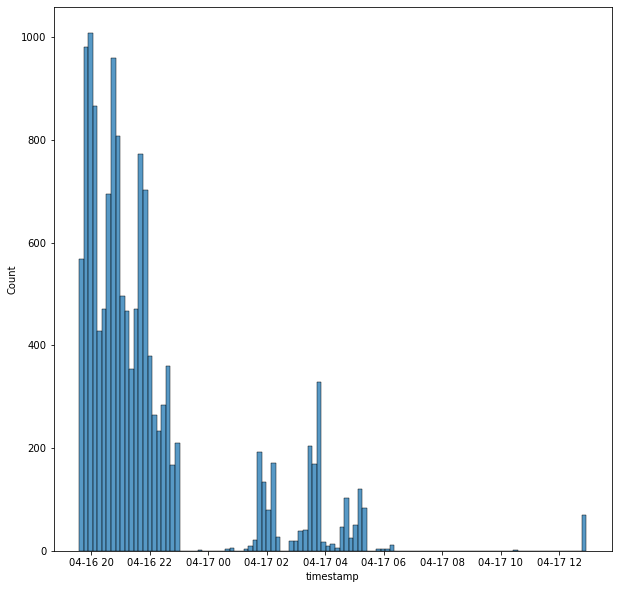

In [29]:
plt.figure(figsize = (10,10))
sns.histplot(data= df, x='timestamp')

majority of traffic takes place on 4-15 within starting at 20h to 23h.  Then throughout the morning on 4-17.

In [36]:
def value_counts_and_frequencies(s: pd.Series, dropna=True) -> pd.DataFrame:
    return pd.merge(
        s.value_counts(dropna=False).rename('count'),
        s.value_counts(dropna=False, normalize=True).rename('proba'),
        left_index=True,
        right_index=True,
    )


value_counts_and_frequencies(df.ip)

,count,proba
97.105.19.58,11998,0.858595
173.173.113.51,1059,0.075784
72.181.113.170,613,0.043867
72.181.105.81,246,0.017604
24.26.242.9,21,0.001503
68.201.219.223,21,0.001503
70.121.214.34,2,0.000143
52.87.230.102,2,0.000143
35.175.171.137,2,0.000143
54.145.52.184,1,0.000072


What are the uncommon ips doing

In [46]:
uncommon_ips = df.ip.value_counts()[df.ip.value_counts() < 3].index.tolist()
df[df.ip.isin(uncommon_ips)]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
223,3.92.201.136,2019-04-16 19:39:14,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
224,52.90.165.200,2019-04-16 19:39:15,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
318,3.88.129.158,2019-04-16 19:40:32,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...
320,34.207.64.242,2019-04-16 19:40:33,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
324,54.172.14.223,2019-04-16 19:40:36,GET,/api/v1/,HTTP/1.1,200,162,Slackbot-LinkExpanding 1.0 (+https://api.slack...
325,34.229.70.250,2019-04-16 19:40:37,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7828,35.175.171.137,2019-04-16 21:22:22,GET,/,HTTP/1.1,200,42,Slackbot-LinkExpanding 1.0 (+https://api.slack...
7829,54.145.52.184,2019-04-16 21:22:22,GET,/favicon.ico,HTTP/1.1,200,162,Slackbot 1.0 (+https://api.slack.com/robots)
7831,52.87.230.102,2019-04-16 21:22:23,GET,/api/v1/sales,HTTP/1.1,200,493905,Slackbot-LinkExpanding 1.0 (+https://api.slack...
8827,35.175.171.137,2019-04-16 21:38:57,GET,/api/v1/items,HTTP/1.1,200,3561,Slackbot-LinkExpanding 1.0 (+https://api.slack...


These might be outliers depending on the server use.  Especially the GET requests on the root of the filesystem.  Especially the ones that are from Mozilla.

Look at some of the other user_agent outliers

In [48]:
df[df.user_agent.str.contains('Mozilla')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
173,97.105.19.58,2019-04-16 19:38:16,GET,/api/V1/HiZach!,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
174,97.105.19.58,2019-04-16 19:38:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
565,97.105.19.58,2019-04-16 19:44:04,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
566,97.105.19.58,2019-04-16 19:44:04,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
582,97.105.19.58,2019-04-16 19:44:16,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
583,97.105.19.58,2019-04-16 19:44:16,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
595,97.105.19.58,2019-04-16 19:44:24,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
596,97.105.19.58,2019-04-16 19:44:24,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
601,97.105.19.58,2019-04-16 19:44:28,GET,/api/v1/stores?page=2,HTTP/1.1,200,1328,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...
602,97.105.19.58,2019-04-16 19:44:28,GET,/favicon.ico,HTTP/1.1,200,162,Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_4...


/favicon.ico is for a webpage hits probably to make the favicon in the browser

still not clear on why slackbot would be hitting the stores api. in particular the  "HiZach!" is suspicious, and "I_DIDNT_DO_IT!!!"

investigate the 97.105.19.58 ip requests

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

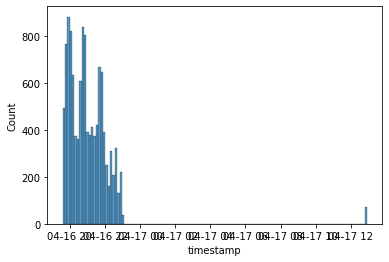

In [50]:
sns.histplot(data=df[df.ip=='97.105.19.58'], x='timestamp')

In [51]:
df[df.user_agent.str.contains('Mozilla')].ip.value_counts()

97.105.19.58      28
72.181.105.81     16
70.121.214.34      2
72.181.113.170     2
Name: ip, dtype: int64

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

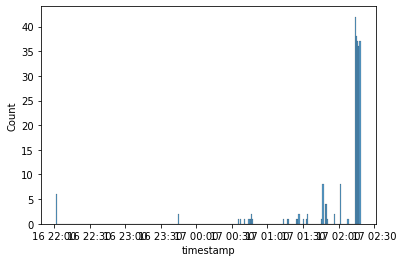

In [52]:
sns.histplot(data=df[df.ip=='72.181.105.81'], x='timestamp')

These, especially 97.105.19.58  might be an instructor.  Therefore this graph:

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

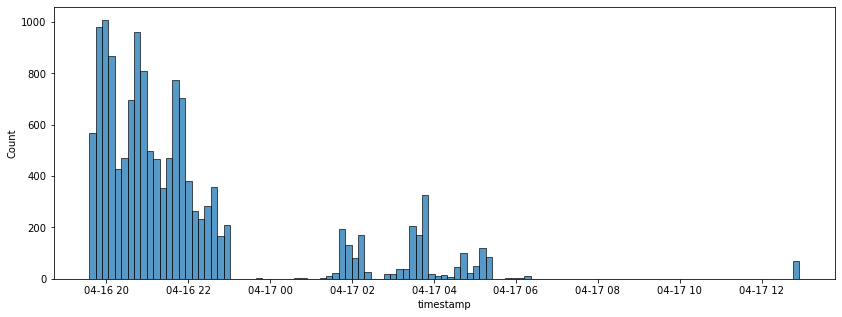

In [56]:
plt.figure(figsize = (14,5))
sns.histplot(data= df, x='timestamp')

Would represent an instructor teaching for until about 4-17 00:00, followed by students working on the project.  Can double check this by considering the ips after and before 4-17 00:00

In [60]:
df[df['timestamp'] > pd.to_datetime('2019-04-17 00:00:00')].ip.value_counts()

173.173.113.51    1059
72.181.113.170     613
72.181.105.81      238
97.105.19.58        70
68.201.219.223      21
24.26.242.9         21
70.121.214.34        2
52.91.30.150         1
52.87.230.102        1
45.23.250.16         1
Name: ip, dtype: int64

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

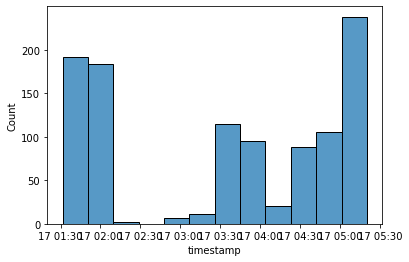

In [61]:
sns.histplot(data=df[df.ip=='173.173.113.51'], x='timestamp')

Could this be the ip for the wifi ap?

## Alternative theories

#### investigate `97.105.19.58` more

In [63]:
df_97 = df[df.ip=='97.105.19.58']
df_97

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0


In [64]:
df_97['change_in_time'] = df_97.timestamp.diff(1)

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_73130/2432635373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_97['change_in_time'] = df_97.timestamp.diff(1)


In [67]:
df_97.change_in_time.describe()

count                        11997
mean     0 days 00:00:05.203967658
std      0 days 00:07:37.100853263
min                0 days 00:00:00
25%                0 days 00:00:00
50%                0 days 00:00:01
75%                0 days 00:00:01
max                0 days 13:54:26
Name: change_in_time, dtype: object

This is actually looks like a webscraper.  What are they scraping?

In [68]:
df_97.request_path.value_counts()

/api/v1/sales?page=2                       698
/api/v1/items                              342
/api/v1/items?page=2                       179
/api/v1/sales                              135
/api/v1/items?page=3                       121
                                          ... 
/api/v1/stores?page=2                        1
/api/V1/HiZach!                              1
/api/v1/items&page=0                         1
/api/v1/                                     1
/api/v1/items?page=99999999999999999998      1
Name: request_path, Length: 216, dtype: int64

In [70]:
df_97[df_97.request_path.str.contains('sales')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,change_in_time
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,NaT
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0 days 00:00:02
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0 days 00:00:02
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0 days 00:00:02
6,97.105.19.58,2019-04-16 19:34:50,GET,/api/v1/sales?page=85,HTTP/1.1,200,510753,python-requests/2.21.0,0 days 00:00:02
...,...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0,0 days 00:00:03
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0,0 days 00:00:00
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0 days 00:00:01
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0,0 days 00:00:00


In [71]:
df_97[df_97.request_path.str.contains('items')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,change_in_time
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:00
9,97.105.19.58,2019-04-16 19:34:53,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:01
10,97.105.19.58,2019-04-16 19:34:53,GET,/api/v1/items?page=2,HTTP/1.1,200,3659,python-requests/2.21.0,0 days 00:00:00
11,97.105.19.58,2019-04-16 19:34:53,GET,/api/v1/items?page=3,HTTP/1.1,200,1787,python-requests/2.21.0,0 days 00:00:00
36,97.105.19.58,2019-04-16 19:35:38,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:01
...,...,...,...,...,...,...,...,...,...
10749,97.105.19.58,2019-04-16 22:19:51,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:00
10773,97.105.19.58,2019-04-16 22:20:12,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:00
10829,97.105.19.58,2019-04-16 22:21:22,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:02
11573,97.105.19.58,2019-04-16 22:44:59,GET,/api/v1/items?page=1,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:02:38


In [73]:
df_97[df_97.request_path.str.contains('stores')]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,change_in_time
5,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00
42,97.105.19.58,2019-04-16 19:35:39,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00
221,97.105.19.58,2019-04-16 19:39:14,GET,/api/v1/stores?page=666,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00
514,97.105.19.58,2019-04-16 19:43:05,GET,/api/v1/stores?page=0,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00
537,97.105.19.58,2019-04-16 19:43:40,GET,/api/v1/stores,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:02
...,...,...,...,...,...,...,...,...,...
10750,97.105.19.58,2019-04-16 22:19:52,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:01
10774,97.105.19.58,2019-04-16 22:20:12,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00
10831,97.105.19.58,2019-04-16 22:21:24,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:01
11574,97.105.19.58,2019-04-16 22:44:59,GET,/api/v1/stores?page=1,HTTP/1.1,200,1328,python-requests/2.21.0,0 days 00:00:00


In [75]:
#majority of the time they are getting information from 3 sources: stores, items and sales
df_97[(df_97.request_path.str.contains('stores'))|(df_97.request_path.str.contains('items'))|(df_97.request_path.str.contains('sales'))]

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent,change_in_time
0,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/sales?page=81,HTTP/1.1,200,512495,python-requests/2.21.0,NaT
1,97.105.19.58,2019-04-16 19:34:42,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0,0 days 00:00:00
2,97.105.19.58,2019-04-16 19:34:44,GET,/api/v1/sales?page=82,HTTP/1.1,200,510103,python-requests/2.21.0,0 days 00:00:02
3,97.105.19.58,2019-04-16 19:34:46,GET,/api/v1/sales?page=83,HTTP/1.1,200,510003,python-requests/2.21.0,0 days 00:00:02
4,97.105.19.58,2019-04-16 19:34:48,GET,/api/v1/sales?page=84,HTTP/1.1,200,511963,python-requests/2.21.0,0 days 00:00:02
...,...,...,...,...,...,...,...,...,...
13969,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=62,HTTP/1.1,200,511544,python-requests/2.21.0,0 days 00:00:03
13970,97.105.19.58,2019-04-17 12:55:12,GET,/api/v1/sales?page=65,HTTP/1.1,200,511201,python-requests/2.21.0,0 days 00:00:00
13971,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=73,HTTP/1.1,200,511781,python-requests/2.21.0,0 days 00:00:01
13972,97.105.19.58,2019-04-17 12:55:13,GET,/api/v1/sales?page=69,HTTP/1.1,200,510136,python-requests/2.21.0,0 days 00:00:00


In [77]:
#majority of the time they are getting information from 3 sources: stores, items and sales
df_97_not_salesetc = df_97[~((df_97.request_path.str.contains('stores'))|(df_97.request_path.str.contains('items'))|(df_97.request_path.str.contains('sales')))]

In [79]:
df_97_not_salesetc.request_path.value_counts()

/                            95
/documentation               93
/favicon.ico                 14
/api/v1/store                 3
/api/V1/HiZach!               1
/api/v1                       1
/api/v1/helloclass!           1
/api/v1/I_DIDNT_DO_IT!!!!     1
/api/v1/                      1
Name: request_path, dtype: int64

#### investingating `173.173.113.51 `

In [81]:
df_173 = df[df.ip=='173.173.113.51']
df_173

,ip,timestamp,request_method,request_path,http_version,status_code,size,user_agent
11967,173.173.113.51,2019-04-17 01:31:30,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0
11968,173.173.113.51,2019-04-17 01:31:56,GET,/,HTTP/1.1,200,42,python-requests/2.21.0
11969,173.173.113.51,2019-04-17 01:31:59,GET,/documentation,HTTP/1.1,200,348,python-requests/2.21.0
11970,173.173.113.51,2019-04-17 01:32:16,GET,/api/v1/items,HTTP/1.1,200,3561,python-requests/2.21.0
11974,173.173.113.51,2019-04-17 01:33:35,GET,/api/v1/sales,HTTP/1.1,200,493905,python-requests/2.21.0
...,...,...,...,...,...,...,...,...
13877,173.173.113.51,2019-04-17 05:20:01,GET,/api/v1/sales?page=179,HTTP/1.1,200,511963,python-requests/2.21.0
13878,173.173.113.51,2019-04-17 05:20:04,GET,/api/v1/sales?page=180,HTTP/1.1,200,510788,python-requests/2.21.0
13879,173.173.113.51,2019-04-17 05:20:07,GET,/api/v1/sales?page=181,HTTP/1.1,200,510317,python-requests/2.21.0
13880,173.173.113.51,2019-04-17 05:20:10,GET,/api/v1/sales?page=182,HTTP/1.1,200,510540,python-requests/2.21.0


In [82]:
df_173['change_in_time'] = df_173.timestamp.diff(1)

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_73130/1999414995.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_173['change_in_time'] = df_173.timestamp.diff(1)


In [84]:
df_173.change_in_time.describe()

count                         1058
mean     0 days 00:00:12.969754253
std      0 days 00:01:32.884894495
min                0 days 00:00:00
25%                0 days 00:00:03
50%                0 days 00:00:03
75%                0 days 00:00:04
max                0 days 00:44:07
Name: change_in_time, dtype: object

In [96]:
df_173[df_173.change_in_time < pd.Timedelta(value=2, unit='second')].request_path.value_counts()

/api/v1/items?page=2    61
/api/v1/items?page=3    61
/api/v1/stores          12
/api/v1/items            2
Name: request_path, dtype: int64

This one looks more normal, it could be someone trying out a webscraper script.

## investigate `request_path`

In [98]:
df_not_salesetc = df[~((df.request_path.str.contains('stores'))|(df.request_path.str.contains('items'))|(df.request_path.str.contains('sales')))]

In [101]:
df_not_salesetc.request_path.value_counts()

/                            107
/documentation               100
/favicon.ico                  26
/api/v1/                       4
/api/v1/store                  3
/api/V1/HiZach!                1
/api/v1                        1
/api/v1/helloclass!            1
/api/v1/I_DIDNT_DO_IT!!!!      1
Name: request_path, dtype: int64

In [107]:
df[df.request_path == '/'].ip.value_counts()

97.105.19.58      95
72.181.105.81      3
68.201.219.223     3
3.92.201.136       1
35.175.171.137     1
70.121.214.34      1
173.173.113.51     1
52.91.30.150       1
72.181.113.170     1
Name: ip, dtype: int64

In [105]:
df[df.request_path == '/documentation'].ip.value_counts()

97.105.19.58      93
72.181.105.81      3
68.201.219.223     3
173.173.113.51     1
Name: ip, dtype: int64

## investigating other ips

In [110]:
df[~df.ip.isin(['173.173.113.51', '97.105.19.58'])].ip.value_counts()

72.181.113.170    613
72.181.105.81     246
24.26.242.9        21
68.201.219.223     21
52.87.230.102       2
35.175.171.137      2
70.121.214.34       2
35.174.209.2        1
52.91.30.150        1
3.92.201.136        1
52.90.165.200       1
54.145.52.184       1
34.229.70.250       1
54.172.14.223       1
34.207.64.242       1
3.88.129.158        1
45.23.250.16        1
Name: ip, dtype: int64

In [116]:
df_72 = df[df.ip == '72.181.113.170']

In [114]:
df_72['change_in_time'] = df_72.timestamp.diff(1)
df_72.change_in_time.describe()

/var/folders/lw/_43z7rb5635_x1dwsyzrnc_m0000gn/T/ipykernel_73130/4042533538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_72['change_in_time'] = df_72.timestamp.diff(1)


count                          612
mean     0 days 00:00:09.805555555
std      0 days 00:01:19.037622452
min                0 days 00:00:00
25%                0 days 00:00:02
50%                0 days 00:00:02
75%                0 days 00:00:02
max                0 days 00:30:20
Name: change_in_time, dtype: object

In [115]:
df_72.request_path.value_counts()

/api/v1/items             38
/api/v1/items?page=2      36
/api/v1/items?page=3      25
/api/v1/sales              5
/api/v1/sales?page=2       5
                          ..
/api/v1/sales?page=154     2
/api/v1/sales?page=155     2
/api/v1/sales?page=183     2
/favicon.ico               1
/                          1
Name: request_path, Length: 189, dtype: int64

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

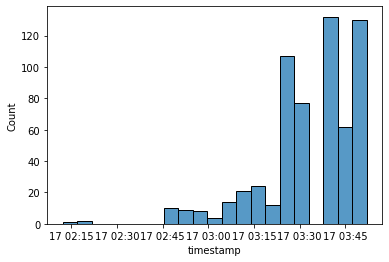

In [118]:
sns.histplot(data = df_72, x='timestamp')

<AxesSubplot:xlabel='timestamp', ylabel='Count'>

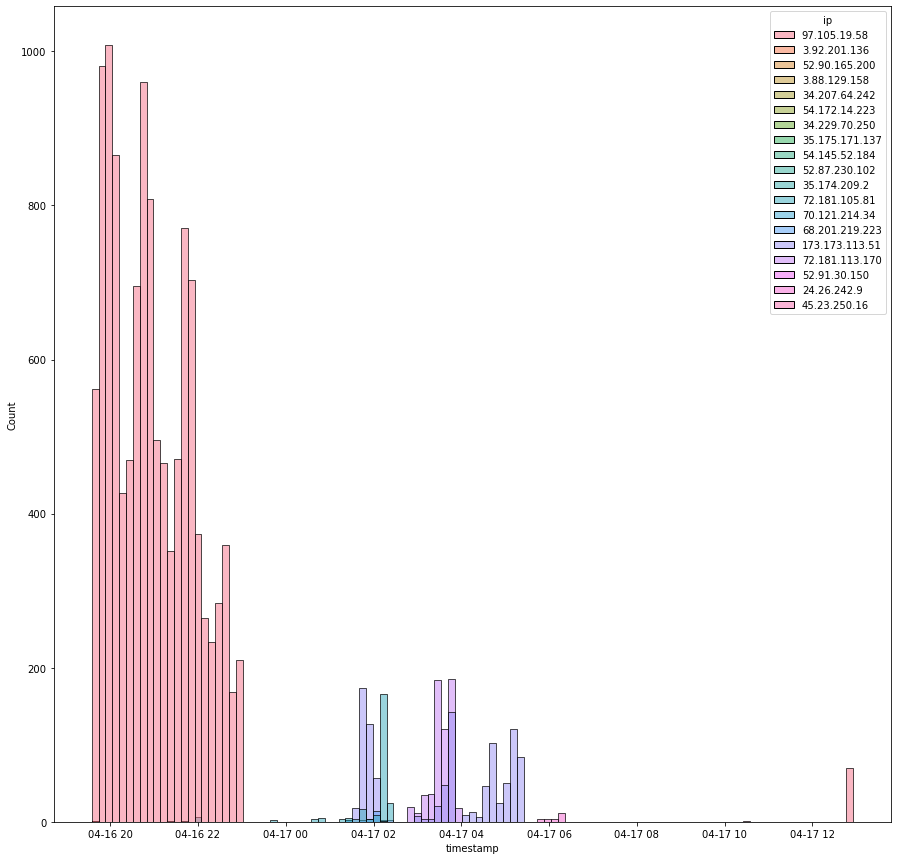

In [121]:
#graph is hard to read, but clearly does show 97.105.19.58 consistently accessing the site
plt.figure(figsize=(15,15))
sns.histplot(data = df, x='timestamp', hue='ip')